In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd drive/MyDrive/sber_risk_spark/lesson_2/

Mounted at /content/drive/
/content/drive/MyDrive/sber_risk_spark/lesson_2


In [2]:
!pip install pyspark findspark nltk

     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 15.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=27c8dc14c355083791b30d535927103190858db85104fd7829e3aa10c13c9241
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import re 
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050')\
                  .set('spark.serializer', 'org.apache.spark.serializer.KryoSerializer')\
                  .set('spark.dynamicAllocation.enabled', 'true')\
                  .set('spark.shuffle.service.enabled', 'true') #трекер, чтобы возвращать ресурсы
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()

In [5]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [6]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2021-12-29 08:55:45--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 52.202.168.65, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  13.19M  38.3MB/s    in 0.3s    

2021-12-29 08:55:45 (38.3 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
get_ipython().system_raw('./ngrok http 4050 &')

In [8]:
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.7/json/__init__.py", line 296, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


Как проще всего создать RDD? Вызвать метод и передать ему нужный объект

In [81]:
first_rdd  = sc.parallelize(range(1000000))

In [82]:
first_rdd.getNumPartitions()

2

А можно ли менять количество партиций? Да, для этого есть два метода: repartition() и coalesce(). Первый используется для увеличения и уменьшения количества партиций, второй только для снижения, прчем coalesce будет работать эффективнее. Много партиций - дольше будет считаться, но если данных много, то обязательно нужно

repartition()` всегда приводит к равномерному перераспределению данных, что ведет к shuffle. Если Вы уменьшаете число партиций, то стоит использовать `coalesce()`, который может избежать shuffle

In [83]:
first_rdd = first_rdd.repartition(5)
print(first_rdd.getNumPartitions())

5


In [84]:
first_rdd = first_rdd.repartition(2)
print(first_rdd.getNumPartitions())

2


In [85]:
first_rdd = first_rdd.coalesce(1)
print(first_rdd.getNumPartitions())

1


In [86]:
a = %time first_rdd.sum()

CPU times: user 24.1 ms, sys: 2.12 ms, total: 26.2 ms
Wall time: 1.84 s


Посмотрим на время выполнения для разного числа партиций

In [15]:
result = []
first_rdd  = sc.parallelize(range(5000000))
for partition in range(1, 30):
    first_rdd = first_rdd.repartition(partition)
    time = %timeit -o  -n 1 -r 1 first_rdd.sum()
    time = time.best
    result.append((partition, time))

1 loop, best of 1: 5.22 s per loop
1 loop, best of 1: 2.54 s per loop
1 loop, best of 1: 2.22 s per loop
1 loop, best of 1: 2.63 s per loop
1 loop, best of 1: 2.75 s per loop
1 loop, best of 1: 2.7 s per loop
1 loop, best of 1: 2.7 s per loop
1 loop, best of 1: 2.86 s per loop
1 loop, best of 1: 2.79 s per loop
1 loop, best of 1: 2.71 s per loop
1 loop, best of 1: 2.83 s per loop
1 loop, best of 1: 2.64 s per loop
1 loop, best of 1: 2.66 s per loop
1 loop, best of 1: 2.68 s per loop
1 loop, best of 1: 2.57 s per loop
1 loop, best of 1: 2.76 s per loop
1 loop, best of 1: 2.71 s per loop
1 loop, best of 1: 2.74 s per loop
1 loop, best of 1: 2.76 s per loop
1 loop, best of 1: 3.13 s per loop
1 loop, best of 1: 3 s per loop
1 loop, best of 1: 3.04 s per loop
1 loop, best of 1: 3.33 s per loop
1 loop, best of 1: 2.96 s per loop
1 loop, best of 1: 3.39 s per loop
1 loop, best of 1: 3.26 s per loop
1 loop, best of 1: 3.28 s per loop
1 loop, best of 1: 3.65 s per loop
1 loop, best of 1: 3.06 s

In [16]:
import matplotlib.pyplot as plt
import os
%matplotlib inline

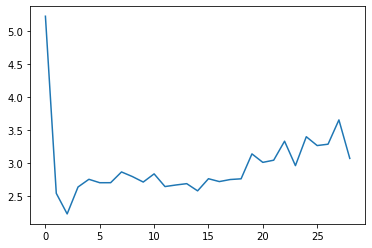

In [17]:
plt.plot([res[1] for res in result])

А почему лучший результат при небольшом количестве партиций?

In [18]:
import multiprocessing

multiprocessing.cpu_count()

2

Из list также можно создавать RDD

In [19]:
bad_list = [1, 2, 3, 'a', 10, 'b']

In [20]:
bad_list_rdd = sc.parallelize(bad_list)

In [21]:
type(bad_list_rdd.collect())

list

Еще можно создать RDD через textFile и wholeTextFiles

In [22]:
text_rdd = sc.textFile('spark_text.txt')

In [23]:
!ls

files				PySpark_RDD.ipynb
ngrok				Spark.pdf
ngrok-stable-linux-amd64.zip	Spark_RDD.pdf
ngrok-stable-linux-amd64.zip.1	spark_text.txt
ngrok-stable-linux-amd64.zip.2	user_ratedmovies.dat
outputs				w2v_vectors.pickle


In [24]:
text_rdd.take(1)

['Apache Spark is an open-source unified analytics engine for large-scale data processing. Spark provides an interface for programming entire clusters with implicit data parallelism and fault tolerance. Originally developed at the University of California, Berkeley AMPLab, the Spark codebase was later donated to the Apache Software Foundation, which has maintained it since.']

wholeTextFiles создает PairRDD в формате key-value, где ключ - имя файла, а значения - то, что находистя в файле. Имена файлов считываются из папки через wholeTextFiles

In [25]:
dirPath = 'files'
os.makedirs(dirPath, exist_ok=True)
with open(os.path.join(dirPath, "1.txt"), "w") as file1:
    _ = file1.write("[1 2 3]")
with open(os.path.join(dirPath, "2.txt"), "w") as file2:
    _ = file2.write("[4 5 6]")
textFiles = sc.wholeTextFiles(dirPath)

In [26]:
textFiles

org.apache.spark.api.java.JavaPairRDD@23e9f712

In [27]:
textFiles.collect()

[('file:/content/drive/My Drive/sber_risk_spark/lesson_2/files/1.txt',
  '[1 2 3]'),
 ('file:/content/drive/My Drive/sber_risk_spark/lesson_2/files/2.txt',
  '[4 5 6]')]

У RDD есть стандартно 2 типа методов - actions и transformations

**Actions**

Начнем с actions, то есть того, что заставит посчитать

In [28]:
first_rdd = first_rdd.coalesce(2)

In [29]:
first_rdd.sum()

12499997500000

In [30]:
first_rdd.min(), first_rdd.max()

(0, 4999999)

In [31]:
first_rdd.first()

406740

In [32]:
first_rdd.take(2)

[406740, 406741]

In [33]:
first_rdd.count()

5000000

In [34]:
a = first_rdd.collect()

In [35]:
len(a), a[:4]

(5000000, [406740, 406741, 406742, 406743])

In [36]:
first_rdd.saveAsTextFile, first_rdd.saveAsPickleFile

(<bound method RDD.saveAsTextFile of CoalescedRDD[165] at coalesce at <unknown>:0>,
 <bound method RDD.saveAsPickleFile of CoalescedRDD[165] at coalesce at <unknown>:0>)

In [37]:
first_rdd.reduce(lambda x, y: x + y)

12499997500000

Если нужно получить небольшое число записей на драйвер и, при этом, сохранить распределение, то лучше сделать выборку

In [38]:
first_rdd.takeSample(withReplacement=False, num=5, seed=5757)

[140278, 3814479, 4519432, 580019, 2341229]

**Transformations**

Это просто трансформации, которые не будут вычисляться до вызова actions

In [39]:
a = sc.parallelize([1, 2, 3])
b = sc.parallelize([2, 3, 4])

In [40]:
c = a + b

In [41]:
c.collect()

[1, 2, 3, 2, 3, 4]

filter

In [42]:
text_rdd.count()

100

In [43]:
text_rdd.take(10)

['Apache Spark is an open-source unified analytics engine for large-scale data processing. Spark provides an interface for programming entire clusters with implicit data parallelism and fault tolerance. Originally developed at the University of California, Berkeley AMPLab, the Spark codebase was later donated to the Apache Software Foundation, which has maintained it since.',
 '',
 'Apache Spark has its architectural foundation in the resilient distributed dataset (RDD), a read-only multiset of data items distributed over a cluster of machines, that is maintained in a fault-tolerant way.[2] The Dataframe API was released as an abstraction on top of the RDD, followed by the Dataset API. In Spark 1.x, the RDD was the primary application programming interface (API), but as of Spark 2.x use of the Dataset API is encouraged[3] even though the RDD API is not deprecated.[4][5] The RDD technology still underlies the Dataset API.[6][7]',
 '',
 'Spark and its RDDs were developed in 2012 in respo

In [44]:
text_rdd.filter(lambda x: x != '').count()

60

In [45]:
text_rdd = text_rdd.filter(lambda x: x != '')

map

In [46]:
stop_words = stopwords.words("english")
stop_words = set(stop_words)

In [47]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [48]:
def mapper_text(text):
    clean_text = re.sub(rf"[{string.punctuation}]", "", text)
    words = nltk.word_tokenize(clean_text)
    words_with_value = [(word.lower(), 1) for word in words 
                        if word not in stop_words]
    return words_with_value

In [49]:
text_rdd.map(mapper_text).take(1)

[[('apache', 1),
  ('spark', 1),
  ('opensource', 1),
  ('unified', 1),
  ('analytics', 1),
  ('engine', 1),
  ('largescale', 1),
  ('data', 1),
  ('processing', 1),
  ('spark', 1),
  ('provides', 1),
  ('interface', 1),
  ('programming', 1),
  ('entire', 1),
  ('clusters', 1),
  ('implicit', 1),
  ('data', 1),
  ('parallelism', 1),
  ('fault', 1),
  ('tolerance', 1),
  ('originally', 1),
  ('developed', 1),
  ('university', 1),
  ('california', 1),
  ('berkeley', 1),
  ('amplab', 1),
  ('spark', 1),
  ('codebase', 1),
  ('later', 1),
  ('donated', 1),
  ('apache', 1),
  ('software', 1),
  ('foundation', 1),
  ('maintained', 1),
  ('since', 1)]]

flatMap

Попробуем применить map и flatMap

In [50]:
text_rdd.map(mapper_text).count()

60

In [51]:
text_rdd.flatMap(mapper_text).count()

1921

In [52]:
text_rdd.flatMap(mapper_text).take(100)

[('apache', 1),
 ('spark', 1),
 ('opensource', 1),
 ('unified', 1),
 ('analytics', 1),
 ('engine', 1),
 ('largescale', 1),
 ('data', 1),
 ('processing', 1),
 ('spark', 1),
 ('provides', 1),
 ('interface', 1),
 ('programming', 1),
 ('entire', 1),
 ('clusters', 1),
 ('implicit', 1),
 ('data', 1),
 ('parallelism', 1),
 ('fault', 1),
 ('tolerance', 1),
 ('originally', 1),
 ('developed', 1),
 ('university', 1),
 ('california', 1),
 ('berkeley', 1),
 ('amplab', 1),
 ('spark', 1),
 ('codebase', 1),
 ('later', 1),
 ('donated', 1),
 ('apache', 1),
 ('software', 1),
 ('foundation', 1),
 ('maintained', 1),
 ('since', 1),
 ('apache', 1),
 ('spark', 1),
 ('architectural', 1),
 ('foundation', 1),
 ('resilient', 1),
 ('distributed', 1),
 ('dataset', 1),
 ('rdd', 1),
 ('readonly', 1),
 ('multiset', 1),
 ('data', 1),
 ('items', 1),
 ('distributed', 1),
 ('cluster', 1),
 ('machines', 1),
 ('maintained', 1),
 ('faulttolerant', 1),
 ('way2', 1),
 ('the', 1),
 ('dataframe', 1),
 ('api', 1),
 ('released', 1

Как так?

In [53]:
text_rdd.map(mapper_text).map(len).sum()

1921

вроде понятно что случилось, но давайте на игрушечном примере

In [54]:
simple_example = sc.parallelize([[1, 2, 3], [2, 3, 4], [4, 5, 6]])

In [55]:
def pow_elements(elements):
    return [x**2 for x in elements]

In [56]:
simple_example.map(pow_elements).collect()

[[1, 4, 9], [4, 9, 16], [16, 25, 36]]

In [57]:
simple_example.flatMap(pow_elements).collect()

[1, 4, 9, 4, 9, 16, 16, 25, 36]

groupByKey

In [58]:
text_rdd = text_rdd.flatMap(mapper_text)

In [59]:
text_rdd.take(3)

[('apache', 1), ('spark', 1), ('opensource', 1)]

In [60]:
text_rdd.groupByKey().mapValues(len).collect()

[('opensource', 1),
 ('unified', 2),
 ('analytics', 5),
 ('engine', 4),
 ('provides', 10),
 ('programming', 9),
 ('entire', 1),
 ('clusters', 2),
 ('implicit', 1),
 ('fault', 1),
 ('tolerance', 1),
 ('originally', 3),
 ('developed', 2),
 ('university', 1),
 ('codebase', 1),
 ('readonly', 2),
 ('multiset', 1),
 ('items', 2),
 ('faulttolerant', 1),
 ('way2', 1),
 ('api', 14),
 ('in', 7),
 ('primary', 1),
 ('use', 9),
 ('encouraged3', 1),
 ('even', 5),
 ('though', 1),
 ('technology', 2),
 ('2012', 1),
 ('response', 2),
 ('limitations', 1),
 ('forces', 1),
 ('particular', 1),
 ('programs', 3),
 ('read', 1),
 ('input', 2),
 ('disk', 3),
 ('reduce', 3),
 ('results', 2),
 ('store', 1),
 ('working', 1),
 ('set', 5),
 ('offers', 3),
 ('deliberately', 1),
 ('form', 2),
 ('memory8', 1),
 ('facilitates', 1),
 ('iterative', 2),
 ('algorithm', 1),
 ('visit', 1),
 ('multiple', 4),
 ('ie', 1),
 ('databasestyle', 1),
 ('querying', 2),
 ('latency', 2),
 ('may', 2),
 ('several', 1),
 ('orders', 1),
 ('ma

sortByKey

In [61]:
text_rdd.groupByKey().mapValues(len).sortByKey(ascending=False).collect()

[('zeromq', 1),
 ('you', 3),
 ('yarn', 2),
 ('written', 2),
 ('writing', 5),
 ('write', 1),
 ('would', 1),
 ('worth', 1),
 ('worlds', 1),
 ('world', 3),
 ('works', 2),
 ('working', 1),
 ('workers', 1),
 ('worker', 1),
 ('work', 2),
 ('words', 2),
 ('within', 1),
 ('wins', 1),
 ('wide', 1),
 ('why', 1),
 ('while', 1),
 ('whereas', 1),
 ('well', 4),
 ('webbased', 1),
 ('we', 1),
 ('ways', 1),
 ('way2', 1),
 ('way', 1),
 ('want', 1),
 ('wabbit24', 1),
 ('vs', 2),
 ('vowpal', 1),
 ('visit', 1),
 ('viewed', 1),
 ('via', 1),
 ('vertices28', 1),
 ('version', 1),
 ('variety', 2),
 ('variant', 1),
 ('variables', 2),
 ('utilized', 1),
 ('usually', 1),
 ('using', 5),
 ('uses', 1),
 ('users', 3),
 ('userdefined', 1),
 ('user', 1),
 ('used', 8),
 ('use', 9),
 ('usable', 1),
 ('updated', 1),
 ('unsuitable', 1),
 ('unlike', 1),
 ('university', 1),
 ('unified', 2),
 ('underlies', 1),
 ('udfs', 1),
 ('uc', 2),
 ('typical', 1),
 ('typed', 1),
 ('typechecking', 1),
 ('type', 1),
 ('twostage', 1),
 ('two'

In [62]:
text_rdd.groupByKey().mapValues(len).sortBy(lambda x: x[1], ascending=False).take(10)

[('spark', 110),
 ('apache', 56),
 ('data', 44),
 ('streaming', 36),
 ('distributed', 23),
 ('processing', 19),
 ('sql', 17),
 ('learning', 15),
 ('rdd', 15),
 ('also', 15)]

И так на самом деле много методов, но предалагаю написать подсчет частоты слов и сделаем это в стиле программ на java

In [63]:
text_rdd = sc.textFile('spark_text.txt')

In [64]:
text_rdd.take(5)

['Apache Spark is an open-source unified analytics engine for large-scale data processing. Spark provides an interface for programming entire clusters with implicit data parallelism and fault tolerance. Originally developed at the University of California, Berkeley AMPLab, the Spark codebase was later donated to the Apache Software Foundation, which has maintained it since.',
 '',
 'Apache Spark has its architectural foundation in the resilient distributed dataset (RDD), a read-only multiset of data items distributed over a cluster of machines, that is maintained in a fault-tolerant way.[2] The Dataframe API was released as an abstraction on top of the RDD, followed by the Dataset API. In Spark 1.x, the RDD was the primary application programming interface (API), but as of Spark 2.x use of the Dataset API is encouraged[3] even though the RDD API is not deprecated.[4][5] The RDD technology still underlies the Dataset API.[6][7]',
 '',
 'Spark and its RDDs were developed in 2012 in respo

In [65]:
result = text_rdd.filter(lambda x: x != '')\
                 .flatMap(mapper_text)\
                 .groupByKey()\
                 .mapValues(len)\
                 .sortBy(lambda x: x[1], ascending=False)\
                 .collect()

In [66]:
result[:10]

[('spark', 110),
 ('apache', 56),
 ('data', 44),
 ('streaming', 36),
 ('distributed', 23),
 ('processing', 19),
 ('sql', 17),
 ('learning', 15),
 ('rdd', 15),
 ('also', 15)]

Забыли про reduceByKey

In [67]:
from operator import add

text_rdd.filter(lambda x: x != '')\
        .flatMap(mapper_text)\
        .reduceByKey(add)\
        .sortBy(lambda x: x[1], ascending=False)\
        .collect()[:10]

[('spark', 110),
 ('apache', 56),
 ('data', 44),
 ('streaming', 36),
 ('distributed', 23),
 ('processing', 19),
 ('sql', 17),
 ('learning', 15),
 ('rdd', 15),
 ('also', 15)]

Стоит заметить, что `groupByKey()` предполагает перемещение всех записей с одним ключом на один экзекьютор. В случае очень скошенных распределений это может привести к падению экзекьютора с OOM. Поэтому всегда при группировках стоит подумать об использовании `reduceByKey()`.

Так, на лекции было что-то про count, который не делает shuffle да и вообще можно проще написать?

In [68]:
def mapper_text_simple(text):
    clean_text = re.sub(rf"[{string.punctuation}]", "", text)
    words = nltk.word_tokenize(clean_text)
    words = [word.lower() for word in words 
                        if word not in stop_words]
    return words

In [69]:
result = text_rdd.filter(lambda x: x != '')\
                 .flatMap(mapper_text_simple)\
                 .countByValue()
result = sorted(result.items(), key=lambda x: x[1], reverse=True)
print(result[:10])

[('spark', 110), ('apache', 56), ('data', 44), ('streaming', 36), ('distributed', 23), ('processing', 19), ('sql', 17), ('rdd', 15), ('learning', 15), ('also', 15)]


In [70]:
tmp = text_rdd.filter(lambda x: x != '')\
              .flatMap(mapper_text_simple)\
              .countByValue()
            
tmp.items()

dict_items([('apache', 56), ('spark', 110), ('opensource', 1), ('unified', 2), ('analytics', 5), ('engine', 4), ('largescale', 1), ('data', 44), ('processing', 19), ('provides', 10), ('interface', 10), ('programming', 9), ('entire', 1), ('clusters', 2), ('implicit', 1), ('parallelism', 1), ('fault', 1), ('tolerance', 1), ('originally', 3), ('developed', 2), ('university', 1), ('california', 1), ('berkeley', 2), ('amplab', 3), ('codebase', 1), ('later', 2), ('donated', 2), ('software', 2), ('foundation', 4), ('maintained', 2), ('since', 1), ('architectural', 1), ('resilient', 2), ('distributed', 23), ('dataset', 7), ('rdd', 15), ('readonly', 2), ('multiset', 1), ('items', 2), ('cluster', 12), ('machines', 1), ('faulttolerant', 1), ('way2', 1), ('the', 9), ('dataframe', 3), ('api', 14), ('released', 1), ('abstraction', 6), ('top', 5), ('followed', 1), ('in', 7), ('1x', 1), ('primary', 1), ('application', 8), ('2x', 3), ('use', 9), ('encouraged3', 1), ('even', 5), ('though', 1), ('depreca

**Join'ы**

Тут просто на игрушечном примере пощупаем данную операцию

In [71]:
rdd_a = sc.parallelize([
                        ('a', [1, 2]),
                        ('b', [2, 4])])

rdd_b = sc.parallelize([
                        ('a', [10]),
                        ('c', [11])])

In [72]:
rdd_a.join(rdd_b).collect()

[('a', ([1, 2], [10]))]

In [73]:
rdd_a.leftOuterJoin(rdd_b).collect()

[('b', ([2, 4], None)), ('a', ([1, 2], [10]))]

In [74]:
rdd_a.fullOuterJoin(rdd_b).collect()

[('b', ([2, 4], None)), ('c', (None, [11])), ('a', ([1, 2], [10]))]

**Домашнее задание 1**

Посчитать количество рейтингов больше 4 для каждого фильма и вывести фильмы в порядке убывания количества этих оценок (можно вывести топ 10)

Файл можете взять из прошлого домашнего задания + сохраните результат на диск

In [75]:
path = '../lesson_1/user_ratedmovies.dat'

In [76]:
with open(path, 'rb') as f:
    data = f.readlines()
headers = data[0].decode().split('\t')[:3]
data = [row.decode().split('\t')[:3] for row in data[1:]]

In [77]:
headers, data[:3]

(['userID', 'movieID', 'rating'],
 [['75', '3', '1'], ['75', '32', '4.5'], ['75', '110', '4']])

In [78]:
def preprocess(line):
    preproc_line = line.split('\t')[:3]
    return preproc_line

In [79]:
data = sc.textFile(path)
data = data.map(preprocess)
headers = data.first()
data = data.filter(lambda x: x!=headers)
data.take(3)

[['75', '3', '1'], ['75', '32', '4.5'], ['75', '110', '4']]

### Variant 1

In [96]:
%timeit data.filter(lambda x: x[2] > '4')\
            .groupBy(lambda x: x[1])\
            .mapValues(lambda x: len(x))\
            .sortBy(lambda x: x[1], ascending=False)\
            .collect()[:10]

1 loop, best of 5: 3.7 s per loop


### Variant 2

In [95]:
%timeit data.filter(lambda x: x[2] > '4')\
            .map(lambda x: (x[1], 1))\
            .reduceByKey(add)\
            .sortBy(lambda x: x[1], ascending=False)\
            .collect()[:10]




1 loop, best of 5: 3.45 s per loop


**Вопрос: можно ли здесь применить .reduceByKey()?**
 
 ```python
     .groupBy(lambda x: x[1])\
     .mapValues(lambda x: len(x))\
 ```
В коде выше происходит грпуппировка по 1-му эдементу строки, который не является `key`, затем замер длины получившегося в процессе группировки списка (`len`).

1. Метода `.reduceBy()` в PySpark нет. Он мог бы позволить кастомную группировку. 
2. Как использовать `len` с `reduce` тоже не понятно

**Домашнее задание 2**

В этом задании у вас есть файл с обученным word2vec на произведении Достоевского Преступление и наказание. Файл - list, каждый элемент которого слово и его вектор в формате ('word', [vector]). Необходимо для каждого слова собрать список его top 10 похожих слов по косинусной метрике
Результат также сохраните на диск и выведите синонимы для слова 'топор' и 'деньга'.
Файл в пикле, так что для считывания воспользуйтесь не spark, можете взять любимый pandas

Файл не очень уж и маленький, рекомендую сначала написать код на кошках/собачках, а потом уже на всем, так как ядра 2, считаться будет очень долго.
В качестве одного из вариантов можете рассмотреть метод cartesian

In [ ]:
import pickle

def get_w2v_data(n=10**5):
    with open('w2v_vectors.pickle', 'rb') as infile:
        w2v = pickle.load(infile)
    print(f'Total number of words available: {len(w2v)}\n')
    w2v = sc.parallelize(w2v[:n])
    return w2v

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


def calc_similar(w2v, select_num=10):
    # 1. delete a diagonal of the pairwise matrix 
    # 2. calc cosine_similarity
    # 3. group by the first word
    # 4. sort values indise bins
    # 5. apply flatMap to flatten the result
    res = w2v.cartesian(w2v)\
            .filter(lambda x: x[0][0] != x[1][0])\
            .map(lambda x: (x[0][0], x[1][0], cosine_similarity([x[0][1]], [x[1][1]])[0][0]))\
            .groupBy(lambda x: x[0])\
            .mapValues(lambda val: sorted(val, key=lambda x: x[2], reverse=True)[:select_num])\
            .flatMap(lambda x: x[1])
    print('Result length:', res.count())

    return res

### Toy example with 10 words

In [ ]:
w2v = get_w2v_data(n=10)

Total number of words available: 4768



In [ ]:
w2v.cartesian(w2v).count()

100

In [ ]:
res = calc_similar(w2v)

Result length: 90


In [ ]:
res.collect()

[('это', 'всё', 0.835629),
 ('это', 'знать', 0.7414978),
 ('это', 'говорить', 0.5983451),
 ('это', 'сказать', 0.5769306),
 ('это', 'раскольник', 0.42143586),
 ('это', 'один', 0.407679),
 ('это', 'человек', 0.37379065),
 ('это', 'весь', 0.3055162),
 ('это', 'свой', 0.1824935),
 ('один', 'свой', 0.57477456),
 ('один', 'весь', 0.5175539),
 ('один', 'говорить', 0.48235622),
 ('один', 'человек', 0.46045557),
 ('один', 'всё', 0.40974388),
 ('один', 'это', 0.407679),
 ('один', 'сказать', 0.37957224),
 ('один', 'знать', 0.3059514),
 ('один', 'раскольник', -0.030425169),
 ('сказать', 'говорить', 0.89675695),
 ('сказать', 'знать', 0.80913687),
 ('сказать', 'это', 0.5769306),
 ('сказать', 'всё', 0.5282705),
 ('сказать', 'один', 0.37957224),
 ('сказать', 'раскольник', 0.28409344),
 ('сказать', 'человек', 0.2601883),
 ('сказать', 'весь', 0.19282101),
 ('сказать', 'свой', 0.17561123),
 ('свой', 'весь', 0.62192565),
 ('свой', 'один', 0.57477456),
 ('свой', 'человек', 0.4078288),
 ('свой', 'говорить',

### Full experiment with 4768 words

In [ ]:
w2v = get_w2v_data()

Total number of words available: 4768



In [ ]:
%%time

res = calc_similar(w2v)

Result length: 47680
CPU times: user 13.1 s, sys: 1.75 s, total: 14.9 s
Wall time: 1h 26min 50s


In [ ]:
print('Partitions num', res.getNumPartitions())

Partitions num 4


In [ ]:
import os

os.makedirs('outputs', exist_ok=True)
res.saveAsTextFile('outputs/most_similar_words')

In [ ]:
res.filter(lambda x: x[0]=='топор').collect()

[('топор', 'левый', 0.92365235),
 ('топор', 'старуха', 0.922432),
 ('топор', 'колено', 0.92066604),
 ('топор', 'побежать', 0.9120595),
 ('топор', 'ломать', 0.9102391),
 ('топор', 'бросить', 0.90634286),
 ('топор', 'схватить', 0.90241086),
 ('топор', 'обнять', 0.899908),
 ('топор', 'бить', 0.89854604),
 ('топор', 'положить', 0.89723605)]

In [ ]:
res.filter(lambda x: x[0]=='деньга').collect()

[('деньга', 'вещь', 0.90631485),
 ('деньга', 'отдать', 0.8706484),
 ('деньга', 'убить', 0.84202707),
 ('деньга', 'значит', 0.8386285),
 ('деньга', 'известно', 0.82667077),
 ('деньга', 'отец', 0.8146181),
 ('деньга', 'получить', 0.81379074),
 ('деньга', 'ограбить', 0.80442435),
 ('деньга', 'копейка', 0.8012078),
 ('деньга', 'полечка', 0.78048533)]